In [1]:
%matplotlib inline
import chess
import matplotlib.pyplot as plt
import cv2

In [2]:
_fen = "rnbqk2r/1p2bppp/p2ppn2/8/3NP3/P1NB4/1PP2PPP/R1BQ1RK1 b kq - 0 8"

In [3]:
board = chess.Board(fen = _fen)

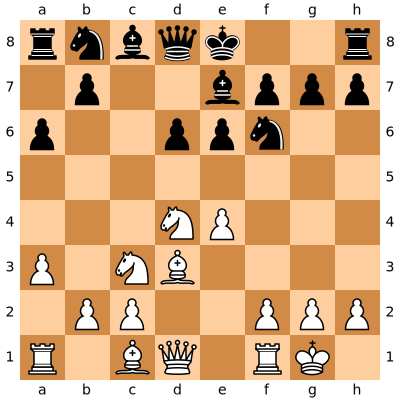

In [4]:
board

In [5]:
def converte_notacao_xadrez_afonso(square_number):
    return (63 - square_number)//8, 7 - (63 - square_number)%8


def generate_matrix_board(board):
    tabuleiro = np.array([(converte_notacao_xadrez_afonso(i), x.symbol()) for i, x in board.piece_map().items()])
    matrix = np.chararray((8, 8))
    matrix[:] = "_"

    for i, x in tabuleiro:
        matrix[i[0], i[1]] = x
    return matrix

In [6]:
matrix = generate_matrix_board(board)

matrix

chararray([[b'r', b'n', b'b', b'q', b'k', b'_', b'_', b'r'],
           [b'_', b'p', b'_', b'_', b'b', b'p', b'p', b'p'],
           [b'p', b'_', b'_', b'p', b'p', b'n', b'_', b'_'],
           [b'_', b'_', b'_', b'_', b'_', b'_', b'_', b'_'],
           [b'_', b'_', b'_', b'N', b'P', b'_', b'_', b'_'],
           [b'P', b'_', b'N', b'B', b'_', b'_', b'_', b'_'],
           [b'_', b'P', b'P', b'_', b'_', b'P', b'P', b'P'],
           [b'R', b'_', b'B', b'Q', b'_', b'R', b'K', b'_']], dtype='|S1')

In [7]:
dc = {}

for peca, counts in zip(*np.unique(matrix, return_counts = True)):
    for i in range(counts):
        dc[peca.decode("utf-8") + f"{i}"] = np.argwhere(matrix == peca)[i]

In [8]:
len(dc)

64

In [9]:
#######

In [10]:
from keras.models import load_model

In [11]:
model = load_model("Models/modelo_raw")

In [12]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 64

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split = 0.2)

train_generator = train_datagen.flow_from_directory(
        'Labels/',  # this is the target directory
        target_size=(70, 70),  # all images will be resized to 150x150
        batch_size=100000,
        class_mode='categorical',
subset = 'training')  # since we use binary_crossentropy loss, we need binary labels
val_generator = train_datagen.flow_from_directory(
        'Labels/',  # this is the target directory
        target_size=(70, 70),  # all images will be resized to 150x150
        batch_size=100000,
        class_mode='categorical',
subset = 'validation')  # since we use binary_crossentropy loss, we need binary labels
x,y = train_generator.next()
x_test, y_test = val_generator.next()

Found 29184 images belonging to 13 classes.
Found 7296 images belonging to 13 classes.


In [14]:
# class_names = ['B', 'K', 'N', 'P', 'Q', 'R', '_', 'b', 'k', 'n', 'p', 'q', 'r']
# np.argmax(y_test, axis = 1)

# n = 53
# plt.imshow(x_test[n])
# print("Predicted: ", class_names[ np.argmax(   y_pred[n] ) ])
# print("Real:", class_names[ np.argmax(   y_test[n] ) ])

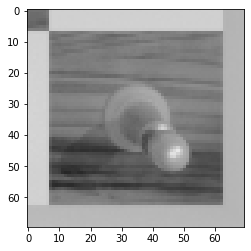

In [15]:
plt.imshow(x_test[15])

In [16]:
%%time
y_pred = model.predict(x_test)

CPU times: user 41.5 s, sys: 4.11 s, total: 45.6 s
Wall time: 14.1 s


In [17]:
y_pred_raw = np.argmax(y_pred, axis = 1)
y_test_raw = np.argmax(y_test, axis = 1)

In [18]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import numpy as np


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    print(unique_labels(y_true, y_pred))
  
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

[ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Confusion matrix, without normalization
[[ 227    0    0    0    1    0    0    0    0    0    0    0    0]
 [   0  114    0    0    0    0    0    0    0    0    0    0    0]
 [   2    0  219    7    0    0    0    0    0    0    0    0    0]
 [   0    0    0  912    0    0    0    0    0    0    0    0    0]
 [   8    0    0    0  106    0    0    0    0    0    0    0    0]
 [   0    0    3    0    0  225    0    0    0    0    0    0    0]
 [   0    0    2    0    0    0 3646    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0  221    5    0    0    2    0]
 [   0    0    0    0    0    0    0    3  111    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0  171   23    0   34]
 [   0    0    0    0    0    0    1    0    0    5  906    0    0]
 [   0    0    0    0    0    0    0   96    5    0    0   12    1]
 [   0    0    2    0    0    0    0    0    0   12    1    0  213]]


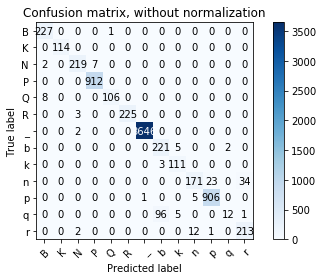

In [19]:
class_names = ['B', 'K', 'N', 'P', 'Q', 'R', '_', 'b', 'k', 'n', 'p', 'q', 'r']
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_raw, y_pred_raw, classes=class_names,
                      title='Confusion matrix, without normalization')


plt.show()

In [ ]:
#####

In [20]:
##### criar imagem com script do blender

In [21]:
def get_squares(img, pts1, i, j, square):
    origem = np.array(pts1[0])
    tr = np.array(pts1[1])
    bl = np.array(pts1[3])
    br = np.array(pts1[2])
    
    #print(origem, tr, ((br - origem) // 16))
     
    
    centro = (origem + ((tr - origem) * i // 8) + ((bl - origem) * j // 8) + ((br - origem) // 16)).astype(int)
    #print(centro)
    return img[centro[1] - square : centro[1] + square, centro[0] - square : centro[0] + square]

In [22]:
def show_full_board(array_geral):
    fig, axs = plt.subplots(8, 8, figsize = (10, 10))
    [axi.set_axis_off() for axi in axs.ravel()]
    for i in range(8):
        for j in range(8):
            axs[i, j].imshow(  get_squares(img_r, pts1, j, i, 35)  , cmap = "gray" )
            #axs[i, j].imshow(get_squares(img_r, pts1, i, j, 35))
    return

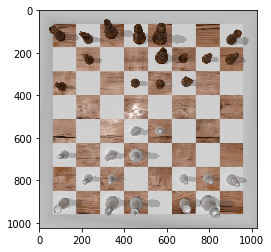

In [23]:
img = cv2.imread("Blender/Blender Imgs/0_from_FEN.png", 1)
img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#cv2.circle(img, (29, 29), 20, 0, thickness = -1)

img = img_RGB
plt.imshow(img)

In [24]:
aux = np.zeros((400, 400), dtype = np.float32)
pts_aux = np.float32([[0,0],[aux.shape[1], 0],[aux.shape[1],aux.shape[0]],[0,aux.shape[0]]])
#pts_aux = np.float32([[int(0.1 * aux.shape[1]),int(0.1 * aux.shape[0])],[int(0.9*aux.shape[1]), int(0.1 * aux.shape[0])],[int(0.9*aux.shape[1]),int(0.9*aux.shape[0])],[int(0.1 * aux.shape[1]), int(0.9*aux.shape[0])]])
img_r = cv2.resize(img, (int(img.shape[1]/2), int(img.shape[0]/2)))


a, b = 29, 481
pts1 = np.array([[a, a], [b, a], [b, b], [a, b]], dtype = np.float32)
M = cv2.getPerspectiveTransform(pts1, pts_aux)
perspectiva = cv2.warpPerspective(img_r, M,(aux.shape[1], aux.shape[0]), aux, borderMode = cv2.BORDER_TRANSPARENT)

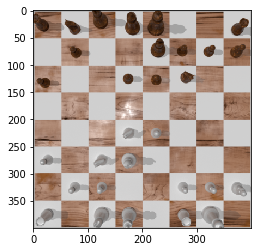

In [25]:
plt.imshow(perspectiva)

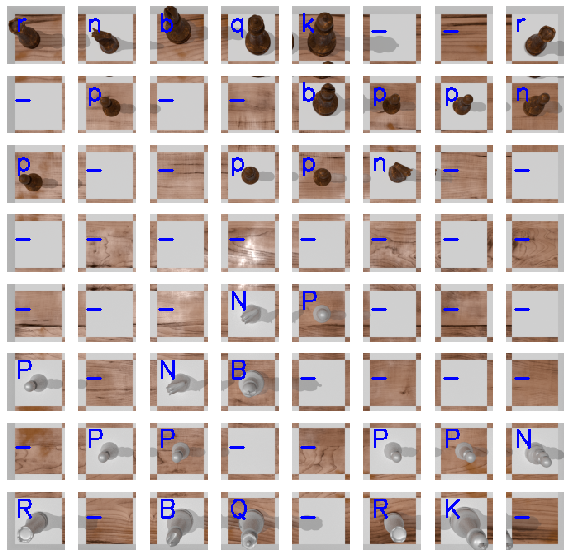

In [26]:
fig, axs = plt.subplots(8, 8, figsize = (10, 10))
[axi.set_axis_off() for axi in axs.ravel()]
for i in range(8):
    for j in range(8):
        square = get_squares(img_r, pts1, j, i, 35)
        
        img_r_ = cv2.cvtColor(img_r, cv2.COLOR_RGB2GRAY)
        idx = model.predict_classes(np.array([cv2.cvtColor(get_squares(img_r_, pts1, j, i, 35), cv2.COLOR_GRAY2BGR)])/255)[0]
        classification = class_names[idx]
        
        cv2.putText(square, classification, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), thickness = 2)
        axs[i, j].imshow(square)